# Interview Question:
## Tomorrow’s Rain Forecast for New York<br>
The Historical Hourly Weather Data 2012-2017 on Kaggle contains 5 years of hourly measurements of various weather attributes, such as temperature, humidity, air pressure, etc. The data are available to download from Kaggle at the following link:<br>
https://www.kaggle.com/selfishgene/historical-hourly-weather-data<br>
### Task: 
<br>Given historical weather data, can you predict whether tomorrow will be rainy in New York? Any weather description that is a form of liquid precipitation is considered rainy, such as those containing keywords “rain”, “thunderstorm”, “drizzle”, etc. You have flexibility in defining “rainy" and “tomorrow” (e.g. next 24 hours from current hour); no matter what your definitions are, please make them clear in the report.
In the open-ended quiz, please make sure you address the following questions:
- Define metrics to evaluate algorithm performance
- What are your training, validation, and testing sets?
- Implement a simple baseline
- Compare the performance of one more algorithm to the baseline
- At least one algorithm should use a machine-learning/deep-learning approach

### Tina's Comments:<br>
This version of notebook is my first trial. In this trial, I will try to do hourly rain prediction. The hourly resolution and info of the raw data might be useful for the end task.

Thus, the target would be a sequence of size 24 (Rain: 0 or 1). This means any next 24 hours is considered as "tomorrow". I do not intend to split "today" and "tomorrow" by wall clock midnight. <br>
I'm going to stick with the definition of rainy in the problem statement, any weather contains "rain", "thunderstorm", or "drizzle" is considered as rainy.
<br><br>
This is a Multivariate Multi-step Time Series prediction problem. I will approach this problem with different flavors of sequence models and frame this as a supervised learning problem.

In [166]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed, Conv1D, MaxPool1D
from itertools import product
from math import sqrt
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

In [167]:
def extract_new_york_info(data_file,column_name,city):
    df=pd.read_csv(data_file)
    ny_df=df[['datetime',city]]
    ny_df.rename(columns={city:column_name}, inplace=True)
    ny_df.set_index('datetime',inplace=True)
    return ny_df

In [168]:
def create_city_dataset(dataset_dir, city):
    data_files = os.listdir(dataset_dir)
    if 'city_attributes.csv' in data_files: data_files.remove('city_attributes.csv') # do not need it for now
    column_names = [x.replace('.csv','') for x in data_files]
#     print(column_names)
    dfs=[]
    for i in range(len(data_files)):
        df = extract_new_york_info(os.path.join(dataset_dir,data_files[i]),column_names[i],city)
        dfs.append(df)
#     print(len(dfs))
    ny_df = pd.concat(dfs, axis=1) # We are lucky here because dataset has no missing datetime index across files
    return ny_df

### Step 1: Load and Clean Data

In [170]:
dataset_dir = 'historical-hourly-weather-data'
city='New York'
ny_df=create_city_dataset(dataset_dir, city)
ny_df.head()

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,weather_description,humidity,wind_direction,temperature,pressure,wind_speed
datetime,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-01 13:00:00,few clouds,58.0,260.0,288.220000,1012.0,7.0
2012-10-01 14:00:00,few clouds,57.0,260.0,288.247676,1012.0,7.0
2012-10-01 15:00:00,few clouds,57.0,260.0,288.326940,1012.0,7.0
2012-10-01 16:00:00,few clouds,57.0,260.0,288.406203,1012.0,7.0


In [5]:
# check if there is any invalid field in the dataset
ny_df.isnull().sum()

weather_description     793
humidity               1624
wind_direction          793
temperature             793
pressure               1041
wind_speed              793
dtype: int64

For humidity, wind_direction, temperature, pressure, and wind_speed, since all the data samples are collected hourly. I think it is reasonble to fill in the missing data with its previous valid record.

In [6]:
# Fill in missing values
ny_df['weather_description'].fillna('None', axis=0, inplace=True)
ny_df.fillna(method='ffill', axis=0, inplace=True)
ny_df.fillna(method='bfill', axis=0, inplace=True)
ny_df.isnull().sum()

weather_description    0
humidity               0
wind_direction         0
temperature            0
pressure               0
wind_speed             0
dtype: int64

#### Now add another column with rain / no rain  label inferred from weather description column,

In [7]:
def is_rainny(value):
    keywords = ['rain','thunderstorm', 'drizzle'] # will label all instances containing these keywords as "rain", otherwise "no rain"
    for x in keywords:
        if x in value:
            return 1
    return 0

In [8]:
ny_df['rainny']=ny_df['weather_description'].apply(is_rainny)
ny_df.tail()

,weather_description,humidity,wind_direction,temperature,pressure,wind_speed,rainny
datetime,,,,,,,
2017-11-29 20:00:00,None,58.0,0.0,284.98,1020.0,2.0,0
2017-11-29 21:00:00,None,58.0,0.0,284.98,1020.0,2.0,0
2017-11-29 22:00:00,None,58.0,0.0,284.98,1020.0,2.0,0
2017-11-29 23:00:00,None,58.0,0.0,284.98,1020.0,2.0,0
2017-11-30 00:00:00,None,58.0,0.0,284.98,1020.0,2.0,0


In [10]:
# drop weather description
cleaned_ny_df = ny_df[['humidity','temperature','pressure','wind_direction','wind_speed','rainny']]

### Step 2: Explore the data and select features

Let's explore the data a bit more to see what variables may have bigger impact on rain conditions.
I'm going to exam the existing 5 features. But there may be some additional features we can extract to help on the prediction task.
From common sense, rain or not should have nothing to do with a specific day. But I suspect it may have some correlation with:<br>
- month
- time (hour) of the day
- humidity diff
- temperature diff
- pressure diff
- wind direction change
- etc.
<br><br>Let's add more features.

In [11]:
# Generate more feature columns
cleaned_ny_df['humidity_diff']=cleaned_ny_df['humidity'].diff()
cleaned_ny_df['temperature_diff']=cleaned_ny_df['temperature'].diff()
cleaned_ny_df['pressure_diff']=cleaned_ny_df['pressure'].diff()
cleaned_ny_df['wind_direction_diff']=cleaned_ny_df['wind_direction'].diff()
cleaned_ny_df['wind_speed_diff']=cleaned_ny_df['wind_speed'].diff()
cleaned_ny_df['month']=pd.to_datetime(cleaned_ny_df.index).month
cleaned_ny_df['hour']=pd.to_datetime(cleaned_ny_df.index).hour
cleaned_ny_df.fillna(0., inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

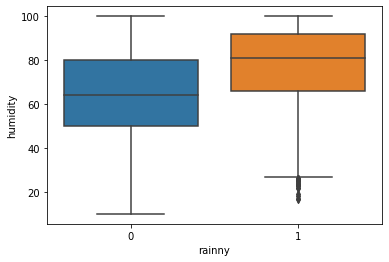

In [12]:
ax_h = sns.boxplot(x="rainny", y="humidity", data=cleaned_ny_df)

In [ ]:
ax_t = sns.boxplot(x="rainny", y="temperature", data=cleaned_ny_df)

In [ ]:
ax_wd = sns.boxplot(x="rainny", y="wind_direction", data=cleaned_ny_df)

In [ ]:
ax_p = sns.boxplot(x="rainny", y="pressure", data=cleaned_ny_df)

In [ ]:
ax_ws = sns.boxplot(x="rainny", y="wind_speed", data=cleaned_ny_df)

In [ ]:
ax_m = sns.boxplot(x="rainny", y="month", data=cleaned_ny_df)

In [ ]:
ax_m = sns.boxplot(x="rainny", y="hour", data=cleaned_ny_df)

In [ ]:
ax_wsd = sns.boxplot(x="rainny", y="wind_speed_diff", data=cleaned_ny_df)

In [ ]:
ax_wdd = sns.boxplot(x="rainny", y="wind_direction_diff", data=cleaned_ny_df)

In [ ]:
ax_td = sns.boxplot(x="rainny", y="temperature_diff", data=cleaned_ny_df)

In [ ]:
ax_pd = sns.boxplot(x="rainny", y="pressure_diff", data=cleaned_ny_df)

In [ ]:
ax_hd = sns.boxplot(x="rainny", y="humidity_diff", data=cleaned_ny_df)

From all the above plots, we can tell that rain or not have big correlation with:
- humidity<br>
Maybe some correlation with:
- temperature
- wind direction
- wind speed
- month<br>
Not much to do with:
- pressure 
- hour
- all the hourly diff values <br>
<br>
So Let's pick humidity, temperature, wind_direction, wind_speed, and month as features for the model.

In [119]:
X = cleaned_ny_df[['humidity', 'temperature', 'wind_direction', 'wind_speed', 'month','rainny']].values# can potentially add rainny label as another feature
y = cleaned_ny_df['rainny'].values

print(X.shape)
print(y.shape)

(45253, 6)
(45253,)


In [120]:
# generated windowed sequence inputs with [# timestep, # features]
def generate_sequence_data(ts_x, ts_y, input_step, output_step):
    inputs=[]
    outputs=[]
    for i in range(len(ts_x)-input_step-output_step):
        sample=ts_x[i:i+input_step]
        label=ts_y[i+input_step:i+input_step+output_step]
        inputs.append(sample)
        outputs.append(label)
    return np.array(inputs), np.array(outputs)

In [121]:
input_step=30*24 # past N days as input
output_step=24 # next 24 hour forecast
sequence_inputs,sequence_labels = generate_sequence_data(X,y,input_step,output_step)
print(sequence_inputs.shape)
print(sequence_labels.shape)

(44509, 720, 6)
(44509, 24)


In [122]:
Xtrain, Xtest, ytrain, ytest = train_test_split(sequence_inputs, sequence_labels, test_size=0.1)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.15)
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)
print(Xtest.shape)
print(ytest.shape)

(34049, 720, 6)
(34049, 24)
(6009, 720, 6)
(6009, 24)
(4451, 720, 6)
(4451, 24)


In [123]:
def scale_features(start, end, source, target):
#     print(target.shape)
    feature_min = np.min(source[start:end], axis=0)
    feature_max = np.max(source[start:end], axis=0)
    denom_factor=np.subtract(feature_max,feature_min)
#     print(feature_max)
#     print(feature_min)
#     print(denom_factor)
    results = np.array([np.divide(np.subtract(x,feature_min),denom_factor) for x in target])
#     print(results.shape)
    return results
# scale_features(34049, 34049+6009, X, Xval)

In [124]:
Xtrain_scaled = scale_features(0, Xtrain.shape[0], X, Xtrain)
Xval_scaled = scale_features(Xtrain.shape[0], Xtrain.shape[0]+Xval.shape[0], X, Xval)
Xtest_scaled = scale_features(Xtrain.shape[0]+Xval.shape[0], len(X), X, Xtest)

In [125]:
def plot_loss_history(history, start=None, end=None):
    if start == None: start=1
    if end == None: end=len(history.history['loss'])
    assert start<end
    assert end<=len(history.history['loss'])
    # Get training and test loss histories
    training_loss = history.history['loss'][start:end]
    test_loss = history.history['val_loss'][start:end]

    # Create count of the number of epochs
    epoch_count = range(start, end)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

### Step 3: Generate dataset for supervised learning purpose
#### 3.1 Simple Baseline
- just simple 1D CNN + Classifier layer

In [129]:
# define model
cnn_model = tf.keras.Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(Xtrain_scaled.shape[1], Xtrain_scaled.shape[2])))
cnn_model.add(MaxPool1D(pool_size=4))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(output_step,activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 718, 64)           1216      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 179, 64)           0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 11456)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                572850    
_________________________________________________________________
dense_25 (Dense)             (None, 24)                1224      
Total params: 575,290
Trainable params: 575,290
Non-trainable params: 0
_________________________________________________________________


Since train and validation losses may fluctuate over the number of epochs, we may have achieved at best model before end of training.<br> So it is best practice to save the best model in the middle of the training. I'm adding a callback during training to only save based on the lowest validation loss.

In [130]:
saved_model_path=os.path.join(os.getcwd(),'CNN.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_model_path,
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True,
        verbose=1
    )

In [131]:
# lstm_model.set_weights(initial_weights)
cnn_history = cnn_model.fit(Xtrain_scaled,ytrain, epochs=20, validation_data=(Xval_scaled,yval), shuffle=True, callbacks=[model_checkpoint_callback])

Train on 34049 samples, validate on 6009 samples
Epoch 1/20
33952/34049 [============================>.] - ETA: 0s - loss: 0.3736 - accuracy: 0.8593
Epoch 00001: val_loss improved from inf to 0.37229, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/CNN.hdf5
34049/34049 [==============================] - 19s 550us/sample - loss: 0.3733 - accuracy: 0.8594 - val_loss: 0.3723 - val_accuracy: 0.8603
Epoch 2/20
33984/34049 [============================>.] - ETA: 0s - loss: 0.3333 - accuracy: 0.8656
Epoch 00002: val_loss improved from 0.37229 to 0.32613, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/CNN.hdf5
34049/34049 [==============================] - 17s 506us/sample - loss: 0.3335 - accuracy: 0.8656 - val_loss: 0.3261 - val_accuracy: 0.8688
Epoch 3/20
34016/34049 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8761
Epoch 00003: val_loss improved from 0.32613 to 0.31731, saving model to /Users/tinawang/ml_experiment

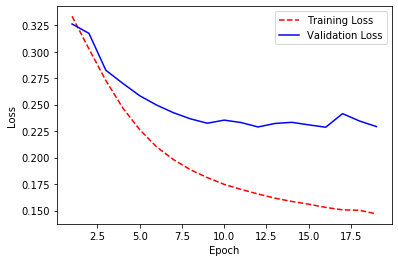

In [132]:
plot_loss_history(cnn_history)

In [44]:
def output_consumer(predictions,threshold):
#     print(predictions.shape)
    flattened_pred=np.array([x.ravel() for x in predictions])
#     print(flattened_pred.shape)
    results=[]
    for pred in flattened_pred:
        result = [0 if x<threshold else 1 for x in pred]
        results.append(result)
    return np.array(results)

In [133]:
# Now load the saved best model to use for inference
cnn_model.load_weights(saved_model_path)
predictions = cnn_model.predict(Xtest_scaled)
# results = output_consumer(test_outputs,0.5)

In [60]:
def evaluate_performance(predictions, labels, assumption):
    '''
    Assumptions:
    A - all 24 hours predictions need to match 1:1 with labels
    B - allow certain window size for positive errors +/- hour error margin (predition is center of the window)
    ex. 
    window_size = 3 condition:
    prediction:  [0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0] ___ OK
    labels:      [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
    prediction:  [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] ___ NOT OK
    labels:      [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

    C - this is the loosest condition, as long as Union(all preditions) == Union(all labels), we are good
    '''
    threshold=0.5
    results = output_consumer(predictions,threshold)
#     print(results.shape)
#     print(labels.shape)
    assert results.shape == labels.shape
    
    if assumption == 'A':
        comp=[]
        for i in range(results.shape[0]):
            ret=np.array_equal(results[i],labels[i])
            comp.append(ret)
        comp=np.array(comp).astype(int)
#         print(comp)
        return comp
    elif assumption == 'B':
        window_size=3 # hard coded here for now
        pass
    elif assumption == 'C':
        comp=[]
        for i in range(results.shape[0]):
            gt=(sum(labels[i])>=1)
            pred=(sum(results[i])>=1)
            ret=(gt==pred)
            comp.append(ret)
        comp=np.array(comp).astype(int)
        return comp
        
    else:
        print('Not Implemented')
    
## TINA WRITE LOGICS FOR B HERE!!!!
# comp=evaluate_performance(predictions, ytest, 'A')

In [138]:
comp=evaluate_performance(predictions, ytest, 'A')
print('Total Test Set: {}\n Number of all correct predictions for next 24 hours: {} Success Rate: {}%'.format(len(comp),sum(comp),sum(comp)/len(comp)*100.))
comp=evaluate_performance(predictions, ytest, 'C')
print('Total Test Set: {}\n Any rain prediction overlap and all no rain prediction correct in next 24 hours: {} Success Rate: {}%'.format(len(comp),sum(comp),sum(comp)/len(comp)*100.))

Total Test Set: 4451
 Number of all correct predictions for next 24 hours: 1520 Success Rate: 34.14962929678724%
Total Test Set: 4451
 Any rain prediction overlap and all no rain prediction correct in next 24 hours: 3177 Success Rate: 71.37721860256121%


#### Whoops! Performance is not great but okay.
The percentage of getting all 24 hours prediction correct is only ~34%, while the success rate for C is ~71% (better than a coin toss).

#### 3.2 More Than Baseline
- CNN + LSTM
- use CNN to help extract some local fetures before feeding into LSTM, which is better designed to detecting trend and seasonality. <br>

In [149]:
# build model
cnn_lstm_model = tf.keras.Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(Xtrain_scaled.shape[1], Xtrain_scaled.shape[2])))
cnn_lstm_model.add(MaxPool1D(pool_size=2))
# cnn_lstm_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# cnn_lstm_model.add(MaxPool1D(pool_size=2))
cnn_lstm_model.add(LSTM(30, return_sequences=True))
cnn_lstm_model.add(LSTM(10, return_sequences=True))
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense(50, activation='relu'))
cnn_lstm_model.add(Dense(24, activation='sigmoid'))
cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm_model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 718, 64)           1216      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 359, 64)           0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 359, 30)           11400     
_________________________________________________________________
lstm_35 (LSTM)               (None, 359, 10)           1640      
_________________________________________________________________
flatten_20 (Flatten)         (None, 3590)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 50)                179550    
_________________________________________________________________
dense_36 (Dense)             (None, 24)              

In [150]:
saved_model_path=os.path.join(os.getcwd(),'CNN_LSTM.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_model_path,
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True,
        verbose=1
    )

In [151]:
cnn_lstm_history = cnn_lstm_model.fit(Xtrain_scaled,ytrain, epochs=20, validation_data=(Xval_scaled,yval), shuffle=True, callbacks=[model_checkpoint_callback])

Train on 34049 samples, validate on 6009 samples
Epoch 1/20
34048/34049 [============================>.] - ETA: 0s - loss: 0.3791 - accuracy: 0.8592
Epoch 00001: val_loss improved from inf to 0.35750, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/CNN_LSTM.hdf5
34049/34049 [==============================] - 263s 8ms/sample - loss: 0.3791 - accuracy: 0.8592 - val_loss: 0.3575 - val_accuracy: 0.8607
Epoch 2/20
34048/34049 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8658
Epoch 00002: val_loss improved from 0.35750 to 0.32651, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/CNN_LSTM.hdf5
34049/34049 [==============================] - 246s 7ms/sample - loss: 0.3424 - accuracy: 0.8658 - val_loss: 0.3265 - val_accuracy: 0.8734
Epoch 3/20
34048/34049 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8779
Epoch 00003: val_loss improved from 0.32651 to 0.30075, saving model to /Users/tinawang/ml_ex

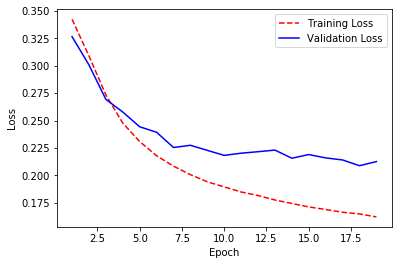

In [152]:
plot_loss_history(cnn_lstm_history)

In [153]:
# Now load the saved best model to use for inference
cnn_lstm_model.load_weights(saved_model_path)
predictions = cnn_lstm_model.predict(Xtest_scaled)
# results = output_consumer(test_outputs,0.5)

In [154]:
comp=evaluate_performance(predictions, ytest, 'A')
print('Total Test Set: {}\n Number of all correct predictions for next 24 hours: {} Success Rate: {}%'.format(len(comp),sum(comp),sum(comp)/len(comp)*100.))
comp=evaluate_performance(predictions, ytest, 'C')
print('Total Test Set: {}\n Any rain prediction overlap and all no rain prediction correct in next 24 hours: {} Success Rate: {}%'.format(len(comp),sum(comp),sum(comp)/len(comp)*100.))

Total Test Set: 4451
 Number of all correct predictions for next 24 hours: 1664 Success Rate: 37.38485733543024%
Total Test Set: 4451
 Any rain prediction overlap and all no rain prediction correct in next 24 hours: 2607 Success Rate: 58.571107616266005%


#### Looking at the Loss plot and the performance, there seems to be room for improvement if we train the network longer.

In [116]:
def evaluate_hourly_performance(predictions, labels):
    print(predictions.shape)
    print(labels.shape)
    assert predictions.shape==labels.shape
    results={}
    for hour in range(labels.shape[1]):
        pred=predictions[:,hour]
        gt=labels[:,hour]
#         print(pred.shape)
        comp=np.equal(pred,gt)
        acc=sum(comp.astype(int))*1./len(comp)
        results[hour]=acc
    print(results)
evaluate_hourly_performance(predictions, ytest)

(4451, 24)
(4451, 24)
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0}


In [117]:
cnn_lstm_history2 = cnn_lstm_model.fit(Xtrain_scaled,ytrain, epochs=20, validation_data=(Xval_scaled,yval), shuffle=True, callbacks=[model_checkpoint_callback])

Train on 34049 samples, validate on 6009 samples
Epoch 1/20
34048/34049 [============================>.] - ETA: 0s - loss: 0.3700 - accuracy: 0.8607
Epoch 00001: val_loss did not improve from 0.36956
34049/34049 [==============================] - 222s 7ms/sample - loss: 0.3700 - accuracy: 0.8607 - val_loss: 0.3720 - val_accuracy: 0.8604
Epoch 2/20
34048/34049 [============================>.] - ETA: 0s - loss: 0.3704 - accuracy: 0.8607
Epoch 00002: val_loss did not improve from 0.36956
34049/34049 [==============================] - 222s 7ms/sample - loss: 0.3704 - accuracy: 0.8607 - val_loss: 0.3727 - val_accuracy: 0.8602
Epoch 3/20
34048/34049 [============================>.] - ETA: 0s - loss: 0.3697 - accuracy: 0.8610
Epoch 00003: val_loss did not improve from 0.36956
34049/34049 [==============================] - 214s 6ms/sample - loss: 0.3697 - accuracy: 0.8610 - val_loss: 0.3738 - val_accuracy: 0.8612
Epoch 4/20
34048/34049 [============================>.] - ETA: 0s - loss: 0.3692 

In [118]:
# Now load the saved best model to use for inference
cnn_lstm_model.load_weights(saved_model_path)
predictions = cnn_lstm_model.predict(Xtest_scaled)
# results = output_consumer(test_outputs,0.5)
comp=evaluate_performance(predictions, ytest, 'A')
print('Total Test Set: {}\n Number of all correct predictions for next 24 hours: {} Success Rate: {}%'.format(len(comp),sum(comp),sum(comp)/len(comp)*100.))
comp=evaluate_performance(predictions, ytest, 'C')
print('Total Test Set: {}\n Any rain prediction overlap and all no rain prediction correct in next 24 hours: {} Success Rate: {}%'.format(len(comp),sum(comp),sum(comp)/len(comp)*100.))

Total Test Set: 4451
 Number of all correct predictions for next 24 hours: 1824 Success Rate: 40.979555156144684%
Total Test Set: 4451
 Any rain prediction overlap and all no rain prediction correct in next 24 hours: 1842 Success Rate: 41.38395866097506%
